In [0]:
# All members equally contributed to this block

# !pip install pyspark
from pyspark import SparkContext, SparkConf 
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import lit
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
import re
import string
from pyspark.ml.feature import (CountVectorizer, Tokenizer,StopWordsRemover, IDF, StringIndexer)

# !pip install nltk
from pyspark.sql.types import ArrayType, FloatType, StringType
from nltk import ngrams

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [0]:
# All members equally contributed to this block


df_test = spark.read.csv("dbfs:/FileStore/shared_uploads/amirabbas.abbaspourm@ucalgary.ca/df_test.csv"
                         , header="true", multiLine="true", escape="\"", sep=',', inferSchema=True)
df_train = spark.read.csv("dbfs:/FileStore/shared_uploads/amirabbas.abbaspourm@ucalgary.ca/df_train.csv"
                          , header="true", multiLine="true", escape="\"", sep=',', inferSchema=True)
df_test_AAM = spark.read.csv("dbfs:/FileStore/shared_uploads/amirabbas.abbaspourm@ucalgary.ca/Amir_Ali_Misagh.csv"
                             , header="true", multiLine="true", escape="\"", sep=',', inferSchema=True)

In [0]:
# All members equally contributed to this block

df_train = df_train.sample(0.15, seed=101)

In [0]:
# All members equally contributed to this block

char_map = [
    ('    ', ' JJJquadspace '),
    ('  ', ' JJJdoublespace '),
    ('\n', ' JJJendline \n JJJnewline '),
    ('\t', ' JJJtabulator '),
    ('~', ' JJJtilde '),
    ('!', ' JJJexclamation '),
    ('@', ' JJJat '),
    ('####', ' JJJquadhash '),
    ('###', ' JJJtriplehash '),
    ('##', ' JJJdoublehash '),
    ('#', ' JJJsinglehash '),
    ('$', ' JJJdollar '),
    ('%', ' JJJpercent '),
    ('^', ' JJJhat '),
    ('&', ' JJJampersand '),
    ('*', ' JJJasterisk '),
    ('(', ' JJJroundbracketopen '),
    (')', ' JJJroundbracketclose '),
    ('_', ' JJJunderscore '),
    ('-', ' JJJminus '),
    ('=', ' JJJequals '),
    ('+', ' JJJplus '),
    ('[', ' JJJsqarebracketopen '),
    (']', ' JJJsqarebracketclose '),
    ('{', ' JJJcurlybracketopen '),
    ('}', ' JJJcurlybracketclose '),
    (';', ' JJJsemicolon '),
    (':', ' JJJcolon '),
    ("'", ' JJJsinglequote '),
    ('"', ' JJJquote '),
    ('\\', ' JJJbackslash '),
    ('|', ' JJJpipe '),
    (',', ' JJJcomma '),
    ('<', ' JJJsmaller '),
    ('.', ' JJJdot '),
    ('>', ' JJJlarger '),
    ('/', ' JJJslash '),
    ('`', ' JJJbacktick '),
    ('?', ' JJJquestion ')]
 
unic_char_map = [
    ('’', ' JJJtick '),
    ('´', ' JJJtick '),
    ('‘', ' JJJtick '),
    ('“', ' JJJsquote '),
    ('”', ' JJJsquote '),
    ('：', ' JJJcolon '),
    ('﹕', ' JJJcolon '),
    ('，', ' JJJcomma '),
    ('…', ' JJJellipsis '),
    ('–', ' JJJminus '),
    ('—', ' JJJminus '),
    ('«', ' JJJpointybracketopen '),
    ('›', ' JJJpointybracketopen '),
    ('»', ' JJJpointybracketclose '),
    ('‹', ' JJJpointybracketclose '),
    ('👉', ' JJJunicodearrow '),
    ('→', ' JJJunicodearrow '),
    ('↓', ' JJJunicodearrow '),
    ('│', ' JJJunicodebox '),
    ('├', ' JJJunicodebox '),
    ('┌', ' JJJunicodebox '),
    ('└', ' JJJunicodebox '),
    ('┤', ' JJJunicodebox '),
    ('┐', ' JJJunicodebox '),
    ('┘', ' JJJunicodebox '),
    ('┬', ' JJJunicodebox '),
    ('─', ' JJJunicodebox '),
    ('║', ' JJJunicodebox '),
    ('╚', ' JJJunicodebox '),
    ('╔', ' JJJunicodebox '),
    ('═', ' JJJunicodebox '),
    ('╗', ' JJJunicodebox '),
    ('╝', ' JJJunicodebox '),
    ('§', ' JJJparagraph '),
    ('·', ' JJJitemize '),
    ('•', ' JJJitemize '),
    ('●', ' JJJitemize '),
    ('✔', ' JJJCheckmark '),
    ('✓', ' JJJCheckmark ')]
 
rec_map = [
    (re.compile(r"(?:(?:[A-Z][a-z0-9]*)+(?:Exception|Error))"), ' JJJexception '),
    (re.compile(r"(?:(?:[A-Z]?[a-z0-9]+)(?:[A-Z][a-z0-9]*)+)"), ' JJJcamelcased '),
    (re.compile(r"(?:(?:\w+_)+\w+)"), ' JJJunderscored '),
    (re.compile(r"(?:0x[a-f0-9]+)"), ' JJJhex '),
    (re.compile(r"\d+"), ' JJJnumber '),
]
 
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t
import logging as log


@f.udf("String")
def replace_special_char(text):
        for rec in rec_map:
            text = rec[0].sub(rec[1], text)
        for repl in char_map:
            text = text.replace(repl[0], repl[1])
        for repl in unic_char_map:
            text = text.replace(repl[0], repl[1])
        return ' JJJnewline ' + text + ' JJJendline '

In [0]:
# All members equally contributed to this block


from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline

def build_ngrams(n=3):
    tokenizer = [
      Tokenizer(inputCol = 'processed',
                outputCol = 'token_text')
    ]
    
    ngrams = [
        NGram(n=i, inputCol="token_text",
              outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    vectorizers = [
        CountVectorizer(inputCol="{0}_grams".format(i),
            outputCol="{0}_counts".format(i))
        for i in range(1, n + 1)
    ]

    assembler = [VectorAssembler(
        inputCols=["{0}_counts".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]

    return Pipeline(stages=tokenizer + ngrams + vectorizers + assembler)

In [0]:
# All members equally contributed to this block


df_trainProcessed = df_train.withColumn("processed", replace_special_char("doc"))
pipeline = build_ngrams()
my_pipeline = pipeline.fit(df_trainProcessed)
transformed_pl = my_pipeline.transform(df_trainProcessed)
train_dataset = transformed_pl.select('target', 'features')
train_dataset = train_dataset.withColumnRenamed('target', 'label')
train_dataset.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,16...|
|    1|(514128,[0,4,5,13...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,4,5,15...|
|    1|(514128,[0,4,5,22...|
|    1|(514128,[0,4,5,12...|
|    1|(514128,[0,4,5,12...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
+-----+--------------------+
only showing top 20 rows



In [0]:
# All members equally contributed to this block

df_testAAMProcessed = df_test_AAM.withColumn("processed", replace_special_char("doc"))
testAAM_dataset = my_pipeline.transform(df_testAAMProcessed)
testAAM_dataset = testAAM_dataset.select('target', 'features')
testAAM_dataset = testAAM_dataset.withColumnRenamed('target', 'label')
testAAM_dataset.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(514128,[0,1,4,5,...|
|    0|(514128,[0,1,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,4,5,10...|
|    0|(514128,[0,2,4,5,...|
|    0|(514128,[0,1,2,3,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,4,5,10...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,1,3,4,...|
|    1|(514128,[0,3,4,5,...|
|    1|(514128,[0,3,4,5,...|
|    1|(514128,[0,4,5,15...|
+-----+--------------------+
only showing top 20 rows



In [0]:
# All members equally contributed to this block

# WARNING TEST SET PIPELINE
# PIPELINE FITTED TO TRAINING SET AND TRANSFORMED TO THE TEST SET
df_testProcessed = df_test.withColumn("processed", replace_special_char("doc"))
test_dataset = my_pipeline.transform(df_testProcessed)
test_dataset = test_dataset.select('target', 'features')
test_dataset = test_dataset.withColumnRenamed('target', 'label')
test_dataset.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,4,5,9,...|
|    1|(514128,[0,4,5,15...|
|    0|(514128,[0,3,4,5,...|
|    0|(514128,[0,3,4,5,...|
|    1|(514128,[0,1,4,5,...|
|    1|(514128,[0,4,5,53...|
|    0|(514128,[0,1,3,4,...|
|    0|(514128,[0,1,2,4,...|
|    0|(514128,[0,2,3,4,...|
|    1|(514128,[0,4,5,6,...|
|    1|(514128,[0,4,5,53...|
|    0|(514128,[0,4,5,11...|
|    0|(514128,[0,1,2,3,...|
|    1|(514128,[0,1,2,4,...|
|    1|(514128,[0,4,5,8,...|
|    1|(514128,[0,3,4,5,...|
+-----+--------------------+
only showing top 20 rows



In [0]:
# Written by Amir Abbaspour

from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier #, RandomForestClassificationModel

In [0]:
# Written by Amir Abbaspour

svc_model = LinearSVC()
rfc_model = RandomForestClassifier()

In [0]:
# Written by Amir Abbaspour

nl_classifier_rfc = rfc_model.fit(train_dataset)

In [0]:
# Written by Amir Abbaspour

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()

predictions_rfc_default_test = nl_classifier_rfc.transform(test_dataset)
print("RFC:\nTest Accuracy of default test set: " + str(evaluator.evaluate(predictions_rfc_default_test, {evaluator.metricName: "accuracy"})))
predictions_rfc_AAM = nl_classifier_rfc.transform(testAAM_dataset)
print("RFC:\nTest Accuracy of Amir, Ali, and Misagh test set: " + str(evaluator.evaluate(predictions_rfc_AAM, {evaluator.metricName: "accuracy"})))

RFC:
Test Accuracy of default test set: 0.7781513983433117
RFC:
Test Accuracy of Amir, Ali, and Misagh test set: 0.8618290258449304


In [0]:
# Written by Amir Abbaspour

import mlflow.sklearn
from sklearn.utils import parallel_backend
from sklearn.metrics import confusion_matrix
import numpy as np

RFC_test_AAM=confusion_matrix(np.array(testAAM_dataset.select("label").collect()), np.array(predictions_rfc_AAM.select("prediction").collect()))
RFC_test_dflt=confusion_matrix(np.array(test_dataset.select("label").collect()), np.array(predictions_rfc_default_test.select("prediction").collect()))

Out[16]: <matplotlib.axes._subplots.AxesSubplot at 0x7f5cace4f4f0>

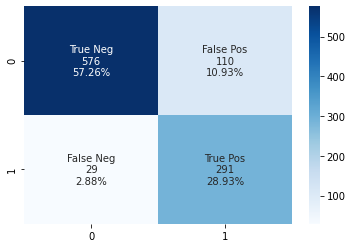

In [0]:
# Written by Amir Abbaspour

import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RFC_test_AAM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RFC_test_AAM.flatten()/np.sum(RFC_test_AAM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RFC_test_AAM, annot=labels, fmt="", cmap='Blues')

Out[17]: <matplotlib.axes._subplots.AxesSubplot at 0x7f5cacea28b0>

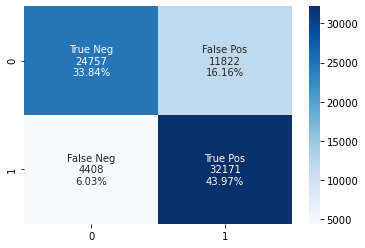

In [0]:
# Written by Amir Abbaspour

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                RFC_test_dflt.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     RFC_test_dflt.flatten()/np.sum(RFC_test_dflt)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RFC_test_dflt, annot=labels, fmt="", cmap='Blues')

In [0]:
# Written by Amir Abbaspour

from sklearn.metrics import classification_report
print("RFC with default test set ")
print(classification_report(test_dataset.select("label").toPandas(),predictions_rfc_default_test.select("prediction").toPandas()))

RFC with default test set 
              precision    recall  f1-score   support

           0       0.85      0.68      0.75     36579
           1       0.73      0.88      0.80     36579

    accuracy                           0.78     73158
   macro avg       0.79      0.78      0.78     73158
weighted avg       0.79      0.78      0.78     73158



In [0]:
# Written by Amir Abbaspour

import pandas as pd
print("RFC with AAM test set ")
print(classification_report(testAAM_dataset.select("label").toPandas(), predictions_rfc_AAM.select("prediction").toPandas()))

RFC with AAM test set 
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       686
           1       0.73      0.91      0.81       320

    accuracy                           0.86      1006
   macro avg       0.84      0.87      0.85      1006
weighted avg       0.88      0.86      0.87      1006



In [0]:
# Written by Amir Abbaspour
# Please note that we ran this model in the previous version of this notebook. The results are erased but we stored them on our local computers and presented them in our reports and presentation.

nl_classifier_svc = svc_model.fit(train_dataset)

In [0]:
# Written by Amir Abbaspour
# Please note that we ran this model in the previous version of this notebook. The results are erased but we stored them on our local computers and presented them in our reports and presentation.

predictions_SVC_default_test = nl_classifier_svc.transform(test_dataset)
print("SVC:\nTest Accuracy of default test set: " + str(evaluator.evaluate(predictions_SVC_default_test,\
                                                 {evaluator.metricName: "accuracy"})))
predictions_SVC_AAM = nl_classifier_svc.transform(testAAM_dataset)
print("SVC:\nTest Accuracy of Amir, Ali, Misagh test set: " + str(evaluator.evaluate(predictions_SVC_AAM,\
                                                 {evaluator.metricName: "accuracy"})))

In [0]:
# Written by Amir Abbaspour
# Please note that we ran this model in the previous version of this notebook. The results are erased but we stored them on our local computers and presented them in our reports and presentation.

SVC_test_AAM=confusion_matrix(np.array(testAAM_dataset.select("label").collect()), np.array(predictions_SVC_AAM.select("prediction").collect()))
SVC_test_dflt=confusion_matrix(np.array(test_dataset.select("label").collect()), np.array(predictions_SVC_default_test.select("prediction").collect()))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                SVC_test_AAM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     SVC_test_AAM.flatten()/np.sum(SVC_test_AAM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVC_test_AAM, annot=labels, fmt="", cmap='Blues')

In [0]:
# Written by Amir Abbaspour
# Please note that we ran this model in the previous version of this notebook. The results are erased but we stored them on our local computers and presented them in our reports and presentation.

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                SVC_test_dflt.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     SVC_test_dflt.flatten()/np.sum(SVC_test_dflt)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVC_test_AAM, annot=labels, fmt="", cmap='Blues')

In [0]:
# Written by Amir Abbaspour
# Please note that we ran this model in the previous version of this notebook. The results are erased but we stored them on our local computers and presented them in our reports and presentation.

print("SVC with AAM test set ")
print(classification_report(testAAM_dataset.select("label").toPandas(), predictions_SVC_AAM.select("prediction").toPandas()))
print("SVC with default test set ")
print(classification_report(test_dataset.select("label").toPandas(), predictions_SVC_default_test.select("prediction").toPandas()))

In [0]:
# Written by Misagh Ishani

from pyspark.ml.classification import LogisticRegression

lr_model = LogisticRegression()
nl_classifier_lr = lr_model.fit(train_dataset)

In [0]:
# Written by Misagh Ishani

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions_lr_default_test = nl_classifier_lr.transform(test_dataset)
predictions_lr_AAM = nl_classifier_lr.transform(testAAM_dataset)

print("LR:\nTest Accuracy of default test set: " + str(evaluator.evaluate(predictions_lr_default_test, {evaluator.metricName: "accuracy"})))
print("LR:\nTest Accuracy of Amir, Ali, and Misagh test set: " + str(evaluator.evaluate(predictions_lr_AAM, {evaluator.metricName: "accuracy"})))

LR:
Test Accuracy of default test set: 0.9405943300801006
LR:
Test Accuracy of Amir, Ali, and Misagh test set: 0.9512922465208747


In [0]:
# Written by Misagh Ishani

import mlflow.sklearn
from sklearn.utils import parallel_backend
from sklearn.metrics import confusion_matrix
import numpy as np

LR_test_AAM=confusion_matrix(np.array(testAAM_dataset.select("label").collect()), np.array(predictions_lr_AAM.select("prediction").collect()))
LR_test_dflt=confusion_matrix(np.array(test_dataset.select("label").collect()), np.array(predictions_lr_default_test.select("prediction").collect()))

Out[39]: <matplotlib.axes._subplots.AxesSubplot at 0x7f36cc6b5f10>

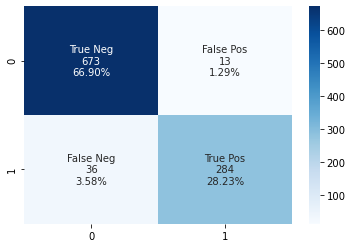

In [0]:
# Written by Misagh Ishani

import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                LR_test_AAM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     LR_test_AAM.flatten()/np.sum(LR_test_AAM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(LR_test_AAM, annot=labels, fmt="", cmap='Blues')

Out[40]: <matplotlib.axes._subplots.AxesSubplot at 0x7f36cd7ee2e0>

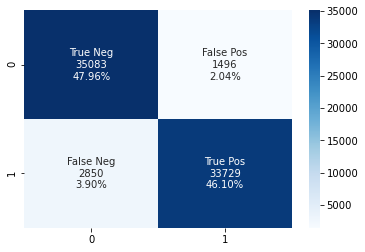

In [0]:
# Written by Misagh Ishani

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                LR_test_dflt.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     LR_test_dflt.flatten()/np.sum(LR_test_dflt)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(LR_test_dflt, annot=labels, fmt="", cmap='Blues')

In [0]:
# Written by Misagh Ishani

from sklearn.metrics import classification_report
print("LR with AAM test set ")
print(classification_report(testAAM_dataset.select("label").toPandas(), predictions_lr_AAM.select("prediction").toPandas()))
print("LR with default test set ")
print(classification_report(test_dataset.select("label").toPandas(), predictions_lr_default_test.select("prediction").toPandas()))

LR with AAM test set 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       686
           1       0.96      0.89      0.92       320

    accuracy                           0.95      1006
   macro avg       0.95      0.93      0.94      1006
weighted avg       0.95      0.95      0.95      1006

LR with default test set 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     36579
           1       0.96      0.92      0.94     36579

    accuracy                           0.94     73158
   macro avg       0.94      0.94      0.94     73158
weighted avg       0.94      0.94      0.94     73158



In [0]:
# Written by Misagh Ishani

train_dataset.count()

Out[11]: 107851

In [0]:
# Written by Misagh Ishani
# Databricks crashed multiple times and then we decided to omit GB

from pyspark.ml.classification import GBTClassifier
gb_model = GBTClassifier()
nl_classifier_gb = gb_model. fit(train_dataset)

java.io.IOException: Connection failed
	at com.databricks.rpc.Jetty9Client$$anon$1.handleError(Jetty9Client.scala:485)
	at com.databricks.rpc.Jetty9Client$$anon$1.onFailure(Jetty9Client.scala:412)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:177)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:169)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.notifyFailureComplete(HttpExchange.java:268)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.abort(HttpExchange.java:240)
	at shaded.v9_4.org.eclipse.jetty.client.HttpConversation.abort(HttpConversation.java:149)
	at shaded.v9_4.org.eclipse.jetty.client.HttpRequest.abort(HttpRequest.java:768)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.abort(HttpDestination.java:453)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.failed(HttpDestination.java:234)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectionPool$1.failed(AbstractConnectionPool.java:140)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at shaded.v9_4.org.eclipse.jetty.client.HttpClient$1$1.failed(HttpClient.java:612)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport.connectFailed(AbstractConnectorHttpClientTransport.java:138)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport$ClientSelectorManager.connectionFailed(AbstractConnectorHttpClientTransport.java:188)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$Connect.failed(ManagedSelector.java:822)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:254)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	... 11 more

In [0]:
# Written by Misagh Ishani
# Databricks crashed multiple times and then we decided to omit GB

predictions_gb_default_test = nl_classifier_gb.transform(test_dataset)
print("GB:\nTest Accuracy of default test set: " + str(evaluator.evaluate(predictions_gb_default_test, {evaluator.metricName: "accuracy"})))
predictions_gb_AAM = nl_classifier_gb.transform(testAAM_dataset)
print("GB:\nTest Accuracy of Amir, Ali, and Misagh test set: " + str(evaluator.evaluate(predictions_gb_AAM, {evaluator.metricName: "accuracy"})))

java.io.IOException: Connection failed
	at com.databricks.rpc.Jetty9Client$$anon$1.handleError(Jetty9Client.scala:485)
	at com.databricks.rpc.Jetty9Client$$anon$1.onFailure(Jetty9Client.scala:412)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:177)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:169)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.notifyFailureComplete(HttpExchange.java:268)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.abort(HttpExchange.java:240)
	at shaded.v9_4.org.eclipse.jetty.client.HttpConversation.abort(HttpConversation.java:149)
	at shaded.v9_4.org.eclipse.jetty.client.HttpRequest.abort(HttpRequest.java:768)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.abort(HttpDestination.java:453)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.failed(HttpDestination.java:234)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectionPool$1.failed(AbstractConnectionPool.java:140)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at shaded.v9_4.org.eclipse.jetty.client.HttpClient$1$1.failed(HttpClient.java:612)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport.connectFailed(AbstractConnectorHttpClientTransport.java:138)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport$ClientSelectorManager.connectionFailed(AbstractConnectorHttpClientTransport.java:188)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$Connect.failed(ManagedSelector.java:822)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:254)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	... 11 more

In [0]:
# Written by Misagh Ishani
# Databricks crashed multiple times and then we decided to omit GB

GB_test_AAM=confusion_matrix(np.array(testAAM_dataset.select("label").collect()), np.array(predictions_gb_AAM.select("prediction").collect()))
GB_test_dflt=confusion_matrix(np.array(test_dataset.select("label").collect()), np.array(predictions_gb_default_test.select("prediction").collect()))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                GB_test_AAM.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     GB_test_AAM.flatten()/np.sum(GB_test_AAM)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(GB_test_AAM, annot=labels, fmt="", cmap='Blues')

java.io.IOException: Connection failed
	at com.databricks.rpc.Jetty9Client$$anon$1.handleError(Jetty9Client.scala:485)
	at com.databricks.rpc.Jetty9Client$$anon$1.onFailure(Jetty9Client.scala:412)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:177)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:169)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.notifyFailureComplete(HttpExchange.java:268)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.abort(HttpExchange.java:240)
	at shaded.v9_4.org.eclipse.jetty.client.HttpConversation.abort(HttpConversation.java:149)
	at shaded.v9_4.org.eclipse.jetty.client.HttpRequest.abort(HttpRequest.java:768)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.abort(HttpDestination.java:453)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.failed(HttpDestination.java:234)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectionPool$1.failed(AbstractConnectionPool.java:140)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at shaded.v9_4.org.eclipse.jetty.client.HttpClient$1$1.failed(HttpClient.java:612)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport.connectFailed(AbstractConnectorHttpClientTransport.java:138)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport$ClientSelectorManager.connectionFailed(AbstractConnectorHttpClientTransport.java:188)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$Connect.failed(ManagedSelector.java:822)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:254)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	... 11 more

In [0]:
# Written by Misagh Ishani
# Databricks crashed multiple times and then we decided to omit GB

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                GB_test_dflt.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     GB_test_dflt.flatten()/np.sum(GB_test_dflt)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(GB_test_dflt, annot=labels, fmt="", cmap='Blues')

java.io.IOException: Connection failed
	at com.databricks.rpc.Jetty9Client$$anon$1.handleError(Jetty9Client.scala:485)
	at com.databricks.rpc.Jetty9Client$$anon$1.onFailure(Jetty9Client.scala:412)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:177)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:169)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.notifyFailureComplete(HttpExchange.java:268)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.abort(HttpExchange.java:240)
	at shaded.v9_4.org.eclipse.jetty.client.HttpConversation.abort(HttpConversation.java:149)
	at shaded.v9_4.org.eclipse.jetty.client.HttpRequest.abort(HttpRequest.java:768)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.abort(HttpDestination.java:453)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.failed(HttpDestination.java:234)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectionPool$1.failed(AbstractConnectionPool.java:140)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at shaded.v9_4.org.eclipse.jetty.client.HttpClient$1$1.failed(HttpClient.java:612)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport.connectFailed(AbstractConnectorHttpClientTransport.java:138)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport$ClientSelectorManager.connectionFailed(AbstractConnectorHttpClientTransport.java:188)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$Connect.failed(ManagedSelector.java:822)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:254)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	... 11 more

In [0]:
# Written by Misagh Ishani
# Databricks crashed multiple times and then we decided to omit GB

print("GB with AAM test set ")
print(classification_report(testAAM_dataset.select("label").toPandas(), predictions_gb_AAM.select("prediction").toPandas()))
print("GB with default test set ")
print(classification_report(test_dataset.select("label").toPandas(), predictions_gb_default_test.select("prediction").toPandas()))

java.io.IOException: Connection failed
	at com.databricks.rpc.Jetty9Client$$anon$1.handleError(Jetty9Client.scala:485)
	at com.databricks.rpc.Jetty9Client$$anon$1.onFailure(Jetty9Client.scala:412)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:177)
	at shaded.v9_4.org.eclipse.jetty.client.ResponseNotifier.notifyFailure(ResponseNotifier.java:169)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.notifyFailureComplete(HttpExchange.java:268)
	at shaded.v9_4.org.eclipse.jetty.client.HttpExchange.abort(HttpExchange.java:240)
	at shaded.v9_4.org.eclipse.jetty.client.HttpConversation.abort(HttpConversation.java:149)
	at shaded.v9_4.org.eclipse.jetty.client.HttpRequest.abort(HttpRequest.java:768)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.abort(HttpDestination.java:453)
	at shaded.v9_4.org.eclipse.jetty.client.HttpDestination.failed(HttpDestination.java:234)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectionPool$1.failed(AbstractConnectionPool.java:140)
	at shaded.v9_4.org.eclipse.jetty.util.Promise$Wrapper.failed(Promise.java:136)
	at shaded.v9_4.org.eclipse.jetty.client.HttpClient$1$1.failed(HttpClient.java:612)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport.connectFailed(AbstractConnectorHttpClientTransport.java:138)
	at shaded.v9_4.org.eclipse.jetty.client.AbstractConnectorHttpClientTransport$ClientSelectorManager.connectionFailed(AbstractConnectorHttpClientTransport.java:188)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$Connect.failed(ManagedSelector.java:822)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:254)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.ConnectException: Connection refused
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	... 11 more